# Data fitting module to do combined fit using gv_lsqfit
### Uses gvar and lsqfit modules.

<a id = 'index'></a>
## Code that contains functions for meson spectroscopy
- [Functions](#funcs)
- [Extract data](#extract data)
- [Fit for AWI quark mass](#awi)
- [Fit for fpi](#fpi)

### Outline:



In [1]:
#!/usr/bin/env python
import psycopg2 as psycopg2
import sqlalchemy as sqla
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib notebook

from IPython.display import display

import gvar as gv
import lsqfit

import sys

<a id ='funcs'></a>

In [2]:
# Modules
def f_meson_awi_fit(x,p):
    '''
    Function for meson fit for AWI quark mass.
    Functional form: 
    c_pi =   a1 [ e^(-m1*t)+ e^{-m1*(L-t)}]
    c_505=  (2 * a1 * mq)/mp [ e^(-m1*t)+ e^{-m1*(L-t)}]
    '''
    
#     # Code to dynamically define variables    
#     for key,val in p.items():
#         exec(key + '=val')
    
    
    a1,mp,mq=p['a1'],p['mp'],p['mq']
    t=x['x']
    L=x['L']
    return {'y1':a1*(np.exp(-mp*t)+np.exp(-mp*(L-t))),'y2':(2*a1*mq)/(1.0*mp)*(np.exp(-mp*t)-np.exp(-mp*(L-t)))}

def f_meson_fpi_fit(x,p):
    '''
    Function for combined meson fit for fpi.
    Functional form: 
    c_smear =  a1^2/( 2 mp) [ e^(-m1*t)+ e^{-m1*(L-t)}]
    c_505   =  (a1 * fpi)/2.0 [ e^(-m1*t)+ e^{-m1*(L-t)}]
    '''
    
#     # Code to dynamically define variables    
#     for key,val in p.items():
#         exec(key + '=val')
    
    a1,mp,fpi=p['a1'],p['mp'],p['fpi']
    t=x['x']
    L=x['L']
    return {'y1':((a1**2)/(2.0*mp))*(np.exp(-mp*t)+np.exp(-mp*(L-t))),'y2':(a1*fpi)/(2.0)*(np.exp(-mp*t)-np.exp(-mp*(L-t)))}


def f_make_p0(par):
    p0=par.copy()
    return p0

def f_make_xy_combined(obs_dict,L,tmax,tmin=3,equil=0,block_size=1):
    '''
    Function to create the dictionaries x and y and all_dta. These are used in the fit.
    x stores xdata with other parameters that never change ('s' and 'L')
    y stores ydata which is a dictionary containing the different observables in the combined fit.
    y={'y1':,'y2':,......}
    fit range includes tmax and tmin
    '''

    for key in obs_dict.keys():
        assert (len(obs_dict[key])>=equil),"Too few data points: %d points in %d, with equil:%d"%(len(obs_dict),key,equil)

    ### IMPORTANT : average with the entire dictionary to get covariance between points and between observables.

    obs_trimmed={k:v[equil:] for k,v in obs_dict.items()}
    obs_data=gv.dataset.avg_data(gv.dataset.bin_data(obs_trimmed,binsize=block_size))
    t_arr=np.arange(min([ len(i) for i in obs_data.values() ]))

    arr_cov=gv.evalcov(obs_data)

    all_dta={'x':t_arr,'y':obs_data}
    
    # Choosing a smaller subset tmin-tmax to fit.
    size=min([ len(i) for i in all_dta['y'].values()]) 
    assert (tmax+1)<size,"tmax %d cannot be greater than total range %d"%(tmax+1,size)
    assert ((tmax+1-tmin)<size),"Selected time range %d > Total range %d "%(tmax+1-tmin,size)
    
#     x={'x':all_dta['x'][tmin:(tmax+1)],'L':L}
    x={'x':np.arange(tmin,tmax+1),'L':L}
    y={k:v[tmin:(tmax+1)] for k,v in all_dta['y'].items()}
    
    return all_dta,x,y,arr_cov


def f_combined_fit_plot(all_dta,fit,error_band=False,semilog=True,full_data=True):
    '''
    Function for plotting data with the fit lines and error bands.
    For correlators, using a semi-log plot.
    full_data=True, plots the entire data and the best-fit in the fit region
    '''
    x,y=fit.x,fit.y
    f, axarr = plt.subplots(len(y), sharex=True)
    
    # Plots data points
    if full_data: # Plot all the correlators even those not used in the fit.
        for count,k in enumerate(all_dta['y'].keys()): # Plot each curve
            axarr[count].errorbar(x=all_dta['x'],y=gv.mean(all_dta['y'][k]),yerr=gv.sdev(all_dta['y'][k]),linestyle='None',marker='o')
        
    else:         # Plot the data points used in the fit
        for count,k in enumerate(y.keys()): # Plot each curve 
            axarr[count].errorbar(x=x['x'],y=gv.mean(y[k]),yerr=gv.sdev(y[k]),linestyle='None',marker='s')
    
    # Plot the best fit line
    # # Using a finer grid to get a continuous curve.
    curvex=dict(x)
    curvex['x']=np.linspace(min(fit.x['x']),max(fit.x['x']),500)
    curvey=gv.mean(fit.fcn(curvex,fit.p))
    for count,k in enumerate(curvey.keys()):
        axarr[count].plot(curvex['x'],curvey[k],color='blue')
        
    if error_band:
        obs_fit=gv.mean(fit.fcn(curvex,fit.p))
        err_fit=gv.sdev(fit.fcn(curvex,fit.p))  
        sigma=2.0
#         print obs_fit,err_fit
    for count,k in enumerate(obs_fit.keys()):
        axarr[count].fill_between(curvex['x'],obs_fit[k]-sigma*err_fit[k],obs_fit[k]+sigma*err_fit[k],color='yellow') # providing an error band.

    if semilog: axarr[0].semilogy()
    axarr[0].set_title('Combined fit')


def f_perform_fit(dta,x,y,L,verbose=True,plot=True,full_data=False,error_band=False,semilog=False):
    
    '''
    Function wrapper to perform correlator fit for mesons.
    Reads dictionary dta with x and y data.
    '''
    print "*****************************",'\n'
    
    # Performing fit

    p0=f_make_p0(par)
    fit = lsqfit.nonlinear_fit(data=(x, y), fcn=f_func, p0=p0,extend=True,svdcut=1e-8)

    # Print the fit results
    if verbose: 
        print f_func.__doc__.strip('\n').strip('  ') # Prints the functional form of fit function.
        print(fit.format(maxline=True)),"\n\n"
    else :
        print fit,"\n\n"

    # Plot fit
    if plot: f_combined_fit_plot(all_dta,fit,full_data=full_data,error_band=error_band,semilog=semilog)
    
    return fit


### Important Gvar tricks:
- Bin data:  
dta=gv.dataset.bin_data(dta[-equil:],binsize=block_size) # equil, block_size needed
- Average data:   
avgs=gv.dataset.avg_data(dta)
- Covariance data:  
covs=gv.evalcov(avgs)

- Extrat from gvar object:
gv.mean(x),gv.sdev(x)

- Note:
    - To get full covariance, use above gv.dataset.bin_data on entire data structure.
    - Works on dictionary too! (see below).

------------------------
Extract data from file into dataframe
------------------------


In [3]:
ls test_data_files/

1column_file.txt                   point_pion_12_24_775_51
covar_fit_test_data.txt            point_ps505_12_24_775_51
get_spectro_data_from_dbase.ipynb  point_smearpion_12_24_775_51
mult_column_file.txt               pointpion_12_24_74_163856


## Extracting data

In [4]:
# Read file into dataframe 
# Reading data for 3 different correlators

data_dir='test_data_files/'
ext='_12_24_775_51'

# POINTPION
fname=data_dir+'point_pion'+ext
df_pion=pd.read_csv(fname,sep='\t').reset_index().drop('index',1)
# df_pointpion
df1=df_pion[:]
# number of rows= num of configurations
# number of columns = number of correlators. Extracted from first entry of dataframe.
n_row=df1.shape[0]
n_col=np.array(df1['corr_data_re'][0].strip('[').strip(']').split(',')).shape[0]
print n_row,n_col
corr_data=np.zeros(shape=(n_row,n_col))
for count,i in enumerate(df1['corr_data_re'].values):
    j=np.array(i.strip('[').strip(']').split(',')).astype(np.float64)
    corr_data[count]=j

corr_point_pion=corr_data[:]

# POINTPS505
fname=data_dir+'point_ps505'+ext
df_pion=pd.read_csv(fname,sep='\t').reset_index().drop('index',1)
df1=df_pion[:]
n_row=df1.shape[0]
n_col=np.array(df1['corr_data_re'][0].strip('[').strip(']').split(',')).shape[0]

corr_data=np.zeros(shape=(n_row,n_col))
for count,i in enumerate(df1['corr_data_re'].values):
    j=np.array(i.strip('[').strip(']').split(',')).astype(np.float64)
    corr_data[count]=j
    
    
corr_point_ps505=corr_data[:]

# SMEARPION
fname=data_dir+'point_smearpion'+ext
df_pion=pd.read_csv(fname,sep='\t').reset_index().drop('index',1)
df1=df_pion[:]
n_row=df1.shape[0]
n_col=np.array(df1['corr_data_re'][0].strip('[').strip(']').split(',')).shape[0]

corr_data=np.zeros(shape=(n_row,n_col))
for count,i in enumerate(df1['corr_data_re'].values):
    j=np.array(i.strip('[').strip(']').split(',')).astype(np.float64)
    corr_data[count]=j

corr_smear_pion=corr_data[:]

## 3 numpy arrays with correlators are : 
# corr_point_pion,corr_point_ps505, corr_smear_poin

46 24


<IPython.core.display.Javascript object>


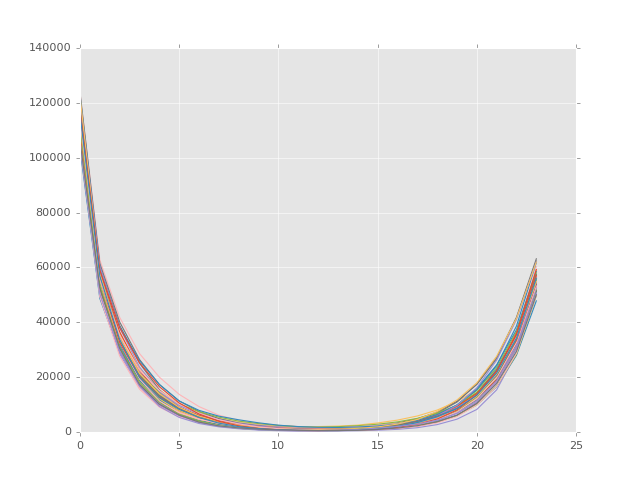

<IPython.core.display.Javascript object>


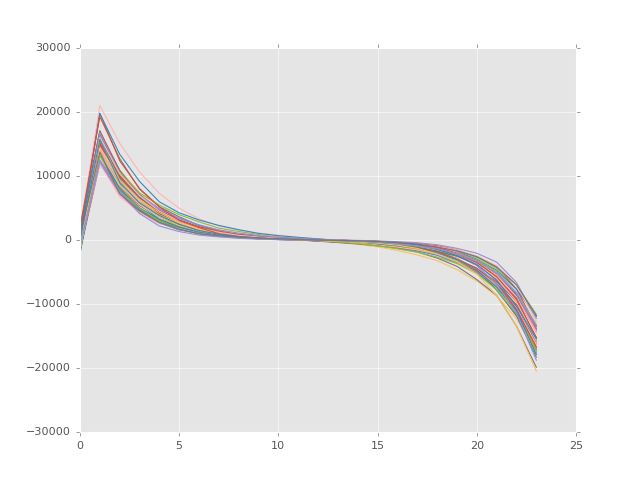

<IPython.core.display.Javascript object>


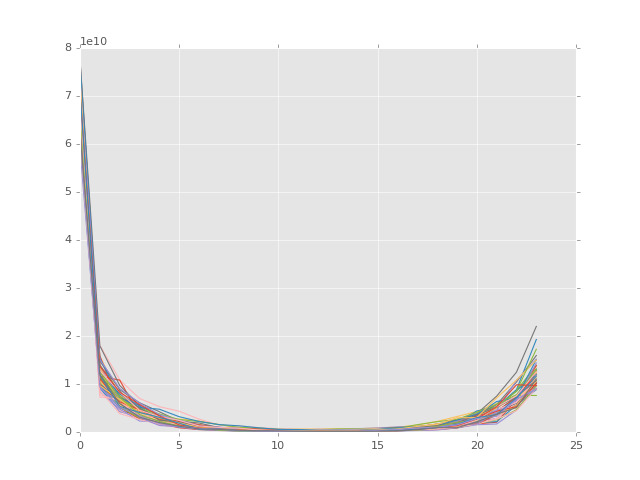

In [11]:
def f_plot_raw_data(corr_data):
    # Plotting raw data before averaging to check behavior
    plt.figure()
    for i in corr_data:
        plt.plot(i)

f_plot_raw_data(corr_point_pion)
f_plot_raw_data(corr_point_ps505)
f_plot_raw_data(corr_smear_pion)



## Fit 1: 


## AWI quark mass fit:
<a id = 'awi'></a>

### $$ C_{\pi} \sim POINTPION = A \left[ e^{-m_{\pi} t } + e^{-m_{\pi} ( L-t)}  \right] $$
### $$ C_{505} \sim POINTPS505 = \frac{ 2 A \ \bf{m_q}}{m_{\pi}} \left[ e^{-m_{\pi} t } - e^{-m_{\pi} ( L-t)}  \right] $$



***************************** 

Function for meson fit for AWI quark mass.
    Functional form: 
    c_pi =   a1 [ e^(-m1*t)+ e^{-m1*(L-t)}]
    c_505=  (2 * a1 * mq)/mp [ e^(-m1*t)+ e^{-m1*(L-t)}]

Least Square Fit (no prior):
  chi2/dof [dof] = 4.2 [9]    Q = 1.6e-05    logGBF = None

Parameters:
             a1   69483 (1902)      [ 66000 +- inf ]  
             mq   0.06785 (34)      [   0.5 +- inf ]  
             mp    0.4315 (72)      [   0.4 +- inf ]  

Fit:
      key        y[key]     f(p)[key]
-------------------------------------
     y1 0    8056 (260)    8053 (233)  
        1    5204 (200)    5248 (180)  
        2    3394 (150)    3435 (139)  
        3    2265 (115)    2271 (108)  
        4     1570 (91)     1537 (85)  
        5     1153 (74)     1094 (69)  
     y2 0    2512 (113)     2520 (99)  
        1     1636 (84)     1632 (74)  
        2     1051 (60)     1052 (54)  
        3      677 (44)      670 (38)  
        4      424 (31)      416 (26)  
        5    

<IPython.core.display.Javascript object>


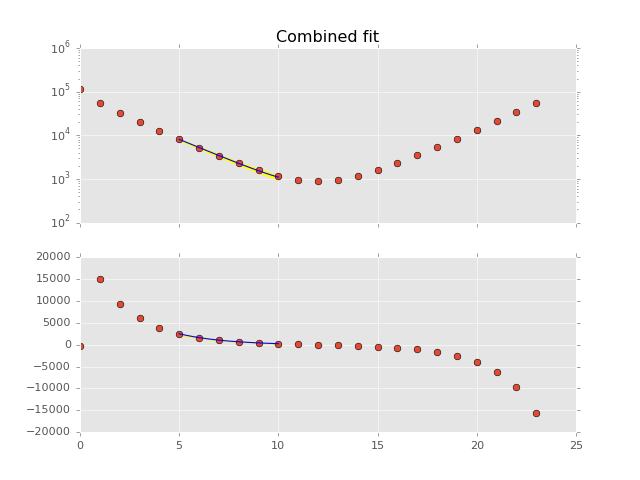

In [5]:
if __name__=='__main__' :
    obs_dict={'y1':corr_point_pion,'y2':corr_point_ps505}
    f_func=f_meson_awi_fit
    L=corr_data.shape[1]
    tmin,tmax=5,10
    all_dta,x,y,cov=f_make_xy_combined(obs_dict,L,tmax=tmax,tmin=tmin,equil=0,block_size=1)
    # Initial guesses for parameters.
    par={'a1':66000,'mp':0.4,'mq':0.5}
    fit=f_perform_fit(all_dta,x,y,L,verbose=True,plot=True,full_data=True,error_band=True,semilog=True)

In [6]:
# dir(fit)


### Fit 2:


<a id = 'fpi'></a>

## $ f_{\pi} $ fit:
### $$ \hat{C}_{\pi} \sim SMEARPION = \frac{A^2}{2 m_{\pi}} \left[ e^{-m_{\pi} t } + e^{-m_{\pi} ( L-t)}  \right] $$
### $$ C_{505} \sim POINTPS505 = \frac{  A \ \bf{f_{\pi}}}{2} \left[ e^{-m_{\pi} t } + e^{-m_{\pi} ( L-t)}  \right] $$
 \begin{eqnarray} 
 L &=& 2 N_t  \ \mbox{( P+A)} \\
   &=& N_t   \  \mbox{  o\w}
  \end{eqnarray}


***************************** 

Function for combined meson fit for fpi.
    Functional form: 
    c_smear =  a1^2/( 2 mp) [ e^(-m1*t)+ e^{-m1*(L-t)}]
    c_505   =  (a1 * fpi)/2.0 [ e^(-m1*t)+ e^{-m1*(L-t)}]

Least Square Fit (no prior):
  chi2/dof [dof] = 1.7 [7]    Q = 0.1    logGBF = None

Parameters:
             a1   111976 (2884)      [ 10000 +- inf ]  
            fpi     0.3795 (65)      [   0.5 +- inf ]  
             mp      0.446 (11)      [   0.4 +- inf ]  

Fit:
      key           y[key]        f(p)[key]
-------------------------------------------
     y1 0     2.59(12)e+09    2.359(90)e+09  *
        1    1.624(89)e+09    1.511(69)e+09  *
        2    1.044(65)e+09     9.70(53)e+08  *
        3     6.63(46)e+08     6.25(40)e+08  
        4     4.71(39)e+08     4.07(30)e+08  *
     y2 0       3837 (151)       3562 (118)  *
        1       2474 (118)        2277 (91)  *
        2        1612 (90)        1453 (70)  *
        3        1034 (64)         924 (52)  *
        4

<IPython.core.display.Javascript object>


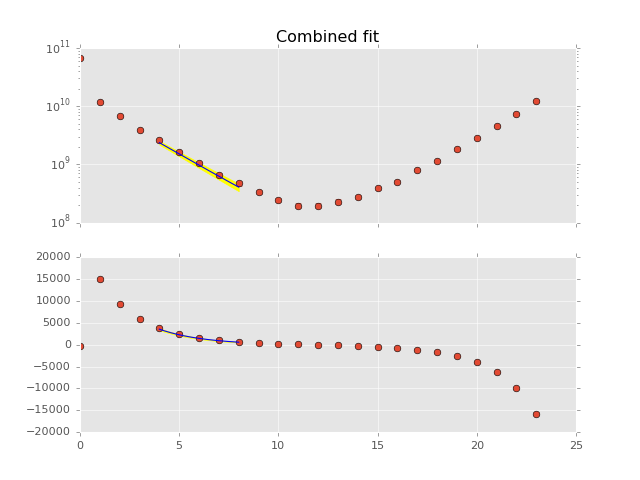

In [14]:
if __name__=='__main__' :
    f_func=f_meson_fpi_fit
    obs_dict={'y1':corr_smear_pion,'y2':corr_point_ps505}

    L=corr_data.shape[1]
    tmin,tmax=4,8
    all_dta,x,y,cov=f_make_xy_combined(obs_dict,L,tmax=tmax,tmin=tmin,equil=10,block_size=1)
    # Initial guesses for parameters.
    par={'a1':10000,'mp':0.4,'fpi':0.5}
    fit=f_perform_fit(all_dta,x,y,L,verbose=True,plot=True,full_data=True,error_band=True,semilog=True)

To do: 
- Fits better now. Still check
- Add 'folding' option
- Add plot for seeing raw data
- Modularize to read 3 files for data input


Add method to use different tmin,tmax and get systematic errors.

[Index](#index)